# DataCamp Certification Case Study

### Project Brief

A housing rental company has hired you for a new project. They are interested in developing an application to help people estimate the money they could earn renting out their living space.

The company has provided you with a dataset that includes details about each property rented, as well as the price charged per night. They want to avoid estimating prices that are more than 25 dollars off of the actual price, as this may discourage people.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder

In [4]:
data = pd.read_csv("data/rentals.csv", index_col=0)
df = data.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8111 entries, 958 to 39354181
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   latitude        8111 non-null   float64
 1   longitude       8111 non-null   float64
 2   property_type   8111 non-null   object 
 3   room_type       8111 non-null   object 
 4   bathrooms       8099 non-null   float64
 5   bedrooms        8107 non-null   float64
 6   minimum_nights  8111 non-null   int64  
 7   price           8111 non-null   object 
dtypes: float64(4), int64(1), object(3)
memory usage: 570.3+ KB


# Data cleaning


**Problems with the dataset:**
1. Drop dduplicated rows
2. Null values are only at 0.1% and 0.004%, and therefore these null rows could be dropped without much loss in information.
3. `price` columns needs cleaning from punctuation marks to convert to `float`.
4. `bedrooms` and `bathrooms` should be whole numbers; round them to `int`.

In [5]:
df[df.duplicated(keep=False)]

,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
id,,,,,,,,
34931081,37.78941,-122.4066,Boutique hotel,Private room,1.0,1.0,5,$199.00
34931105,37.78941,-122.4066,Boutique hotel,Private room,1.0,1.0,5,$199.00


In [6]:
df.drop_duplicates(inplace=True)
df.shape

(8110, 8)

In [7]:
(df.isna().sum() / len(df))

latitude          0.000000
longitude         0.000000
property_type     0.000000
room_type         0.000000
bathrooms         0.001480
bedrooms          0.000493
minimum_nights    0.000000
price             0.000000
dtype: float64

Majorly, NaN values belong to properties of the same type in the same neighbourhoud.

In [8]:
df_nan = df[df.isna().any(axis=1)]
df_nan

,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
id,,,,,,,,
144978,37.79336,-122.42506,Apartment,Private room,NaN,1.0,30,$56.00
229240,37.79341,-122.40340,Hostel,Shared room,NaN,1.0,1,$45.00
259621,37.79470,-122.40374,Hostel,Shared room,NaN,1.0,1,$45.00
259622,37.79441,-122.40473,Hostel,Shared room,NaN,1.0,1,$45.00
430692,37.75906,-122.40761,Apartment,Private room,NaN,1.0,31,$68.00
431862,37.78321,-122.41969,Apartment,Entire home/apt,1.0,NaN,30,$124.00
596042,37.79384,-122.42436,Apartment,Private room,NaN,1.0,30,$63.00
785901,37.79313,-122.40443,Hostel,Shared room,NaN,1.0,1,$45.00
786492,37.79421,-122.40310,Hostel,Shared room,NaN,1.0,1,$45.00


In [9]:
df.dropna(inplace=True)
df[['bedrooms', 'bathrooms']] = df[['bedrooms', 'bathrooms']].astype(int)
df = df[(df.bedrooms > 0) & (df.bathrooms > 0)]

df.price = df.price.str.replace('$', '', regex=False)
df.price = df.price.str.replace(',', '', regex=False)
df.price = df.price.astype('float')
df = df[df.price > 0]
df.dtypes

latitude          float64
longitude         float64
property_type      object
room_type          object
bathrooms           int32
bedrooms            int32
minimum_nights      int64
price             float64
dtype: object

# Univariate analysis
Investigate 
**Categorical cols:**


* `property_type`
* `room_type`


**Numerical cols:**
* `bedrooms`
* `bathrooms`
* `minimum_nights`
* `price`

Numeric columns except latitude and logitude have alot of extreme values. They should be visually investigated.

In [10]:
df.describe(percentiles=[0.25, 0.5, 0.75, 0.95])

,latitude,longitude,bathrooms,bedrooms,minimum_nights,price
count,7184.000000,7184.000000,7184.000000,7184.000000,7.184000e+03,7184.000000
mean,37.764872,-122.431222,1.386275,1.509187,1.393592e+04,236.111498
std,0.022963,0.027274,0.930936,0.850301,1.179823e+06,434.543599
min,37.704740,-122.513060,1.000000,1.000000,1.000000e+00,10.000000
25%,37.750330,-122.443775,1.000000,1.000000,2.000000e+00,100.000000
50%,37.766465,-122.426060,1.000000,1.000000,4.000000e+00,159.000000
75%,37.782590,-122.411520,1.000000,2.000000,3.000000e+01,250.000000
95%,37.799406,-122.393876,3.000000,3.000000,3.000000e+01,599.000000
max,37.828790,-122.368570,14.000000,14.000000,1.000000e+08,10000.000000


## Price

The price column is right skewed with very extreme data points. They will be further investigate as to discern whether they should be removed or not

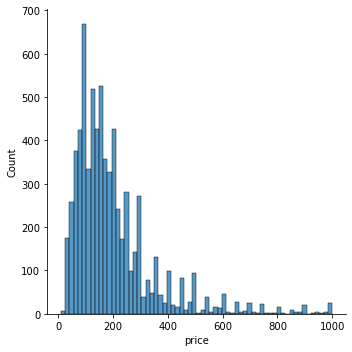

In [11]:
sns.displot(data=df[df.price < 1000], x='price')

To further investigate extreme values $> 450$ USD, they were plotted with different property types, and it seems that values above `2000` are extremely rare, they definitely look like outliers. Values below 2000 are common for the plotted property types and, therefore, shouldn't be immediatley dismissed until further investigation.

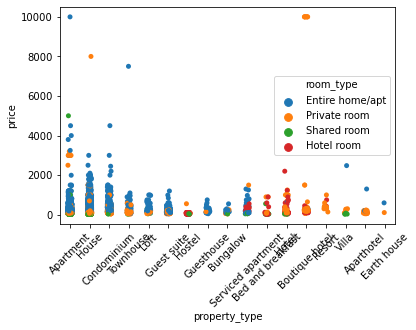

In [12]:
df_expensive = df[df.price > 450]
expensive_properties = list(df_expensive.property_type.unique())

ax = sns.stripplot(data=df[df.property_type.isin(expensive_properties)], x='property_type', y='price', hue='room_type')
locs, labels = plt.xticks()
_ = plt.setp(labels, rotation=45)

The extreme prices $> 2000$ USD are mostly rooms with 1 or 2 bedrooms and bathrooms. Maybe they represent a certain unique class of rooms.

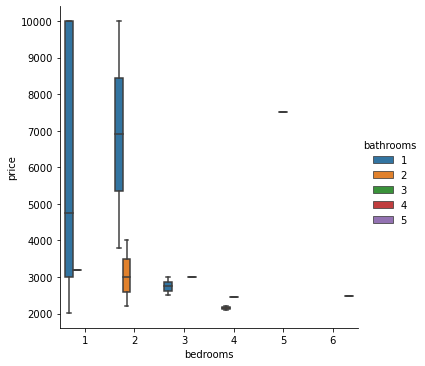

In [13]:
sns.catplot(data=df[df.price > 2000], kind='box', x='bedrooms', y='price', hue='bathrooms')

Boutique hotel with Private room type are the reason for these high values, comparing them to other boutique hotel listings will reveal whether they are special in anyway given the data we have.

In [14]:
df_expensive[df_expensive.price > 6000].sort_values(by='price', ascending=False)

,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
id,,,,,,,,
36185102,37.78898,-122.41659,Boutique hotel,Private room,1,1,1,10000.0
36185260,37.79240,-122.42060,Boutique hotel,Private room,1,1,1,10000.0
36185321,37.79404,-122.42202,Boutique hotel,Private room,1,1,1,10000.0
36185365,37.79196,-122.42184,Boutique hotel,Private room,1,1,1,10000.0
36185403,37.79396,-122.42200,Boutique hotel,Private room,1,1,1,10000.0
36185434,37.79334,-122.42046,Boutique hotel,Private room,1,1,1,10000.0
36185495,37.79341,-122.42051,Boutique hotel,Private room,1,1,1,10000.0
51374,37.76519,-122.45613,Apartment,Entire home/apt,1,2,365,9999.0
14887262,37.74255,-122.47917,House,Private room,1,1,1,8000.0


### Explore extreme `price` values
### `Boutique hotel` with `Private room`
#### `bedrooms` ad `bathrooms`
In terms of number of bedrooms and bathrooms, the majority of listings have either 1 or 2 bedrooms and bathrooms. Extreme values are mostly when the number of bedrooms and bathrooms is 1, it could be possible that they represent a luxury category of rooms.

The room with 14 bedrooms and bathrooms looks like an oulier, and will, therefore, be removed from the analysis.

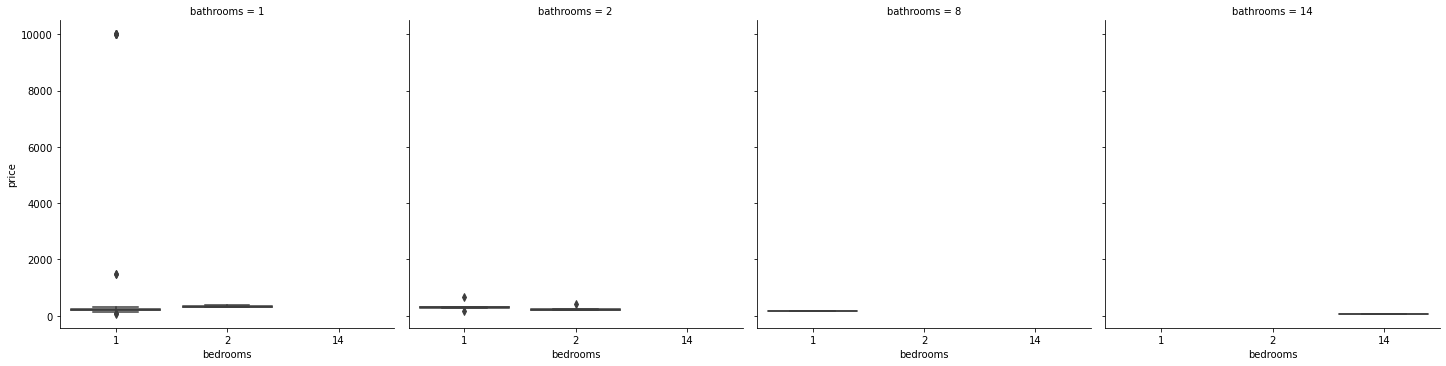

In [15]:
# Explore values under `Boutique hotel` and `Private room` to detect patterns which could help isolate extreme values. 
df_boutique = df[(df.property_type == 'Boutique hotel') & (df.room_type == 'Private room')]
sns.catplot(data=df_boutique, kind='box', x='bedrooms', col='bathrooms', y='price')

#### `location`
Some of the Boutique hotel properties with large readings are clustered more towards the center of the city, however, there is an overlap with the other price categories, it is difficult to assign them to a different cluster.

There is also an overlap between moderate and expensive classes. 

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

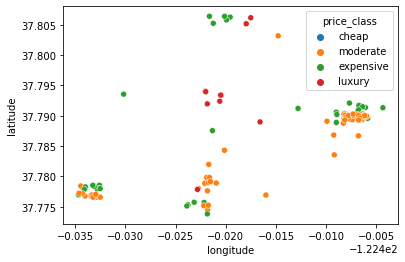

In [16]:
# Bin prices to categories, and scatter plot data geographically to see if extreme values are location specific
df_boutique.insert(0, 'price_class', pd.cut(df_boutique.price, bins=[0, 60, 200, 400, 150000], labels=['cheap', 'moderate', 'expensive', 'luxury']))
sns.scatterplot(data=df_boutique, x='longitude', y='latitude', hue='price_class')

### `Apartment` and `Entire home/apt`
#### `bedrooms` and `bathrooms`

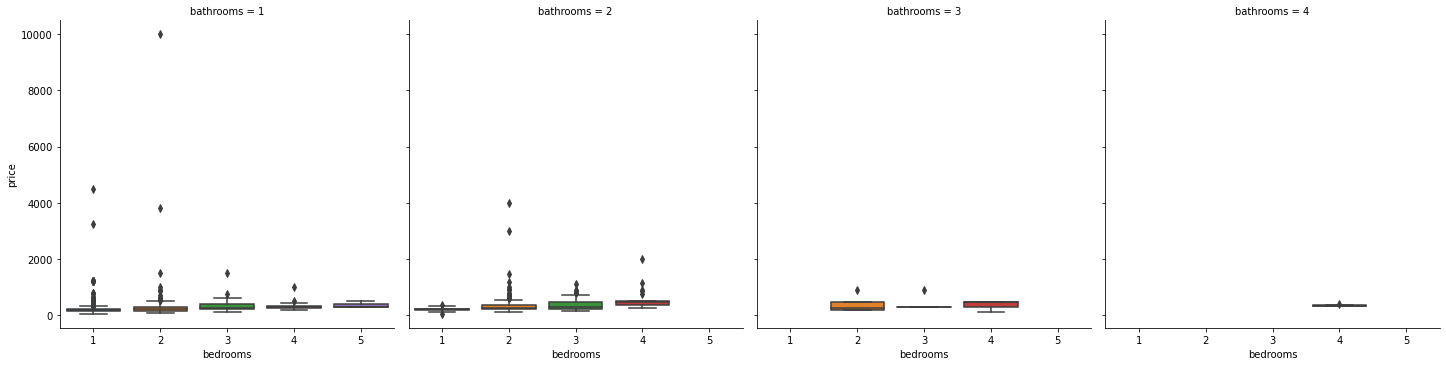

In [17]:
# Isolate Apartments with properties showing in extreme values
df_apt = df[(df.property_type == 'Apartment') & (df.room_type == 'Entire home/apt')]

# Compare Apartments with average prices vs extreme prices, in terms of number of bedrooms and bathrooms
sns.catplot(data=df_apt, x='bedrooms', col='bathrooms', kind='box',y='price')

#### `location`

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

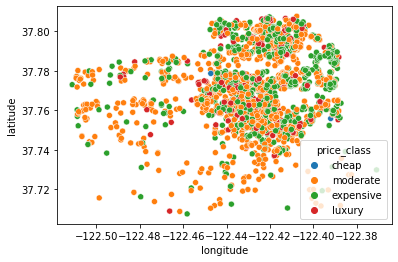

In [18]:
# Compare data points with extreme values with common data points geographically
df_apt.insert(0, 'price_class', pd.cut(df_apt.price, bins=[0, 60, 200, 400, 150000], labels=['cheap', 'moderate', 'expensive', 'luxury']))
sns.scatterplot(data=df_apt, x='longitude', y='latitude', hue='price_class')

### `House` and `Private room`
#### `bedrooms` and `bathrooms`

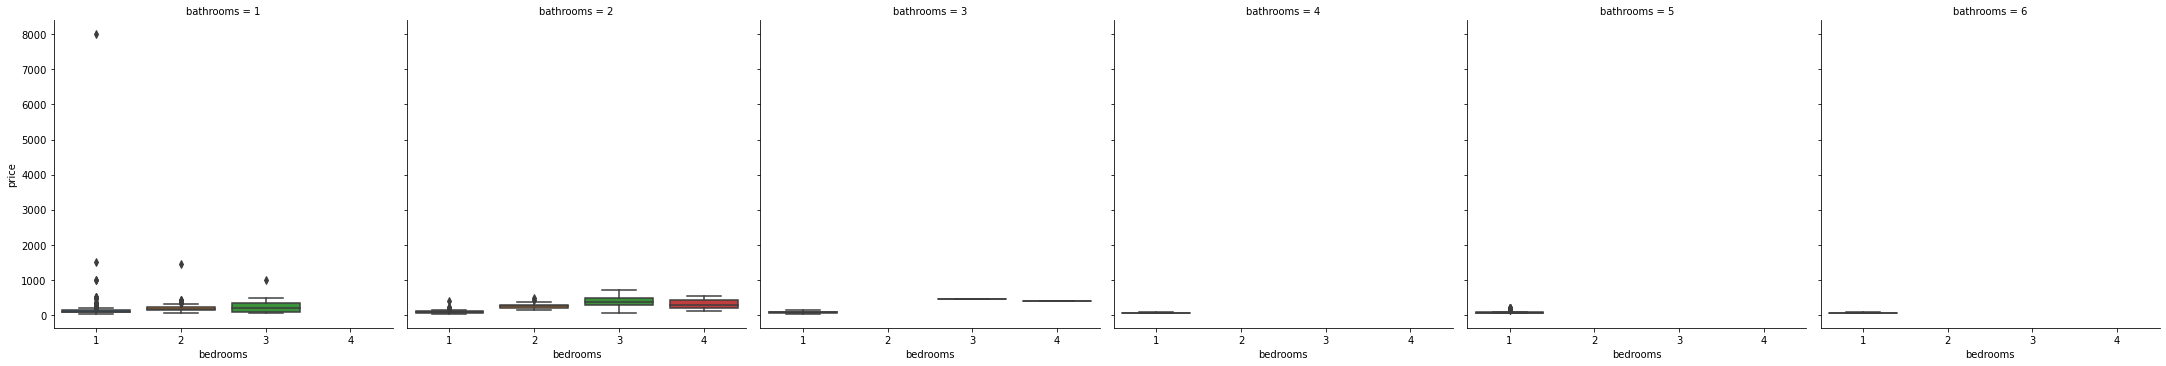

In [19]:
df_house = df[(df.property_type == 'House') & (df.room_type == 'Private room')]
sns.catplot(data=df_house, kind='box', x='bedrooms', y='price', col='bathrooms')

#### `location`

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

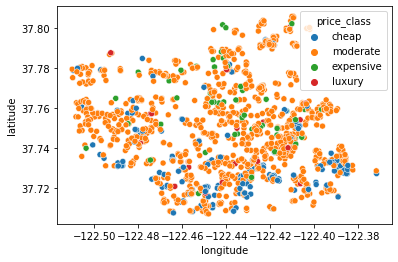

In [20]:
df_house.insert(0, 'price_class', pd.cut(df_house.price, bins=[0, 60, 200, 400, 150000], labels=['cheap', 'moderate', 'expensive', 'luxury']))
sns.scatterplot(data=df_house, x='longitude', y='latitude', hue='price_class')

The extreme values couldn't be justified with the features available, in order to draw better insights from the data, these values will be removed. To get rid of the outliers, I'll log transform price to get a normal distribution and drop values that are more than 2.5 standard deviations away.

drop values that are 2 std deviations away at: 7 corresponding to 1052 usd


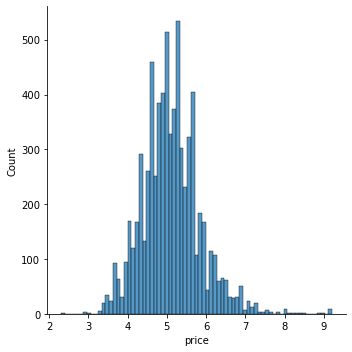

In [21]:
log_price = np.log(df.price)
sns.displot(data=log_price)

cutoff_price = log_price.mean() + log_price.std() * 2.5
print("drop values that are 2 std deviations away at: " + str(round(cutoff_price)) + ' corresponding to ' + str(round(np.exp(cutoff_price))) + ' usd')


df = df[df.price < np.exp(cutoff_price)]

## Property type


Many of property types have small values, they will be investigated in terms of price to see which could be merged with the `property type`, `Other`.

Rare types


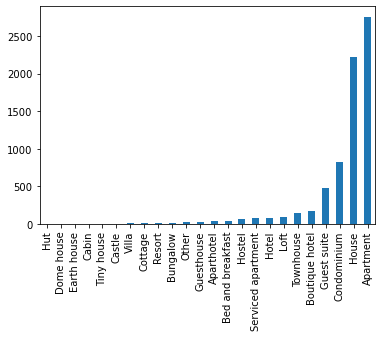

In [22]:
print('Rare types')
_ = df.property_type.value_counts().sort_values().plot(kind='bar')

Property types `Cottage`, `Bungalow`, `Tiny house`, `Villa`, `Cabin`, `Dome house` are not so different from `Other` in terms of prices. They could be merged together. 

`Castle`, `Earth house` and `Hut` are too few to be standalone, and will cause imbalance during training

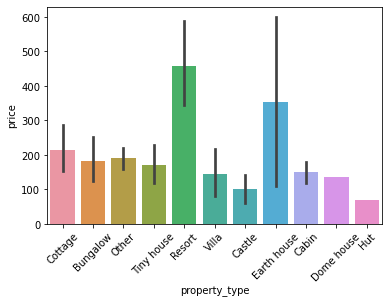

In [23]:
rare_properties = list(df.property_type.value_counts()[(df.property_type.value_counts() < 24)].index)
df_rare_properties = df[df.property_type.isin(rare_properties + ['Other'])]
sns.barplot(data=df_rare_properties, x='property_type', y='price')
_ = plt.xticks(rotation=45)

df = df.replace(['Cottage', 'Bungalow', 'Tiny house', 'Villa', 'Cabin', 'Dome house', 'Castle', 'Earth house', 'Hut'], 'Other')

## Room type

Room types `Entire home/apt` and `Private room` are the most frequent among the 4 most common propertiy types. 

In [24]:
df.room_type.value_counts()

Entire home/apt    4043
Private room       2642
Shared room         226
Hotel room          168
Name: room_type, dtype: int64

In general, some room types are extremely rare for certain properties, and may cause imbalance in the dataset after splitting. They should be further investigated as to whether they have unique values under other features or not, otherwise they should be dropped before analysis.

<AxesSubplot:xlabel='property_type'>

<Figure size 1080x720 with 0 Axes>

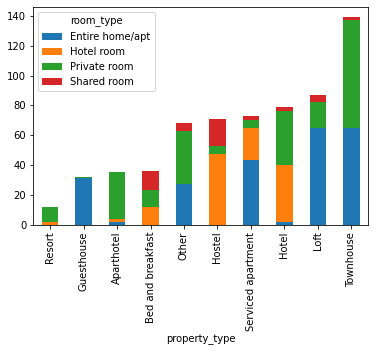

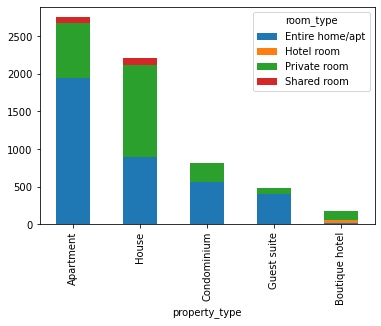

In [25]:
plt.figure(figsize=(15, 10))

df_grouped = pd.pivot_table(data=df, index='property_type', columns='room_type', values='price', aggfunc='count')
df_grouped['total'] = df_grouped.fillna(0).sum(axis=1)
df_grouped = df_grouped.sort_values(by='total', ascending=False)

df_grouped.nsmallest(10, 'total').drop('total', axis=1).plot(kind='bar', stacked=True)
df_grouped.nlargest(5, 'total').drop('total', axis=1).plot(kind='bar', stacked=True)

## Bedrooms
The majority of rentals have just one bedroom.

Some private rooms have more than 1 bedroom. Maybe the number of bedrooms was incorrectly registered as the number of bedrooms in the entire property rather than in the room itself.

<AxesSubplot:xlabel='room_type', ylabel='bedrooms'>

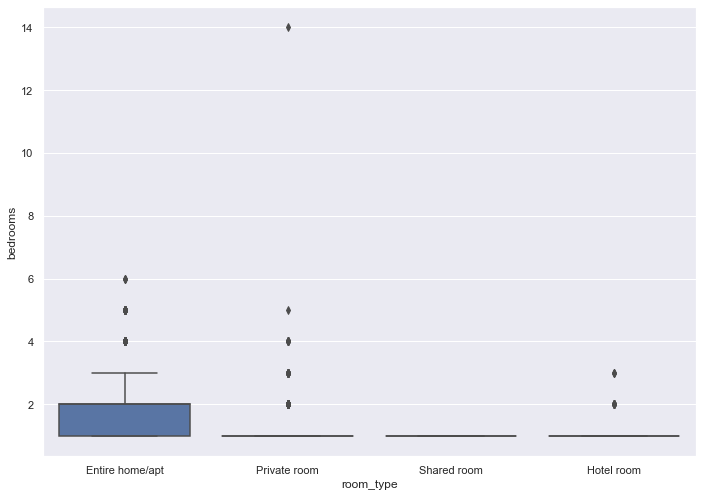

In [26]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(data=df, x='room_type', y='bedrooms')

The average number of bedrooms is very close to 1 for the majority of property types.

`property types` which are rare, are those with average slightly higher than 1 bedroom, and this could mean two things:
1. Rare property types belong to some kind of a luxurious room category
2. Data for rare property types are too few and most susceptible for entry error.

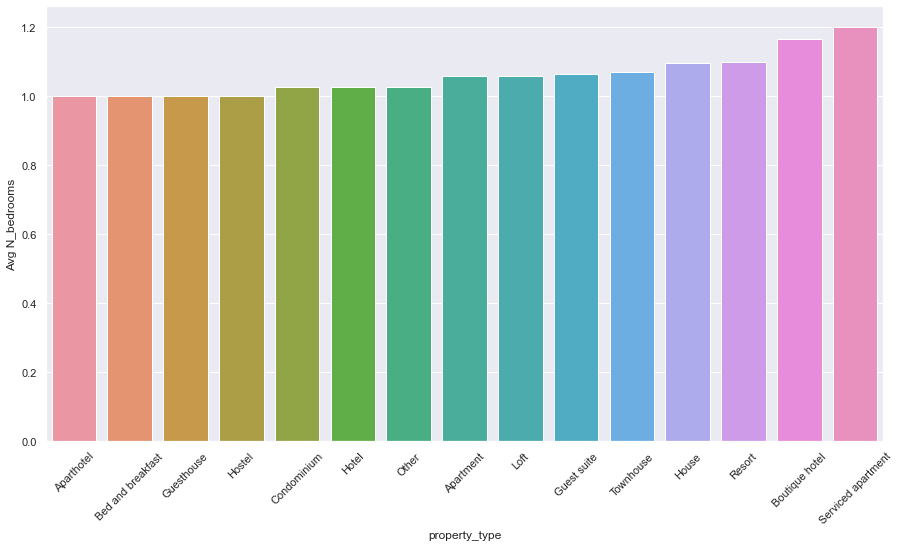

In [27]:
private_room =df[df.room_type == 'Private room']

plt.figure(figsize = (15,8))
ax = sns.barplot(
    data=private_room.groupby('property_type', as_index=False).agg({'bedrooms':'mean'}).sort_values(by='bedrooms'), 
    x='property_type', y='bedrooms')

locs, labels = plt.xticks()
plt.ylabel('Avg N_bedrooms')
_ = plt.setp(labels, rotation=45)

* For private rooms the data follows a logical trend as the bedroom number increases, until 5 bedrooms are reached.
* Outliers are mostly under rooms with 1 bedroom.

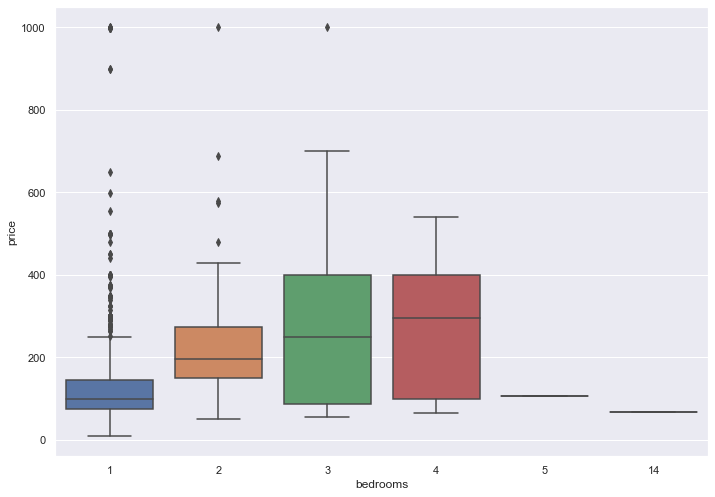

In [28]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(data=private_room, x='bedrooms', y='price')

df = df.loc[~((df.room_type == 'Private room') & (df.bedrooms > 4)), :]

Overall, alot of the data don't seem right, they may be outliers. Futher investigation with bivariate analysis will give more insight. It is recommended to use trees as ML model, to minimize the effect of these noisy data.

## Bathrooms


Private rooms have a large number of extreme values in terms of number of bathrooms, therefore, I'll isolate them, in terms of the `property type` for futher investigation.

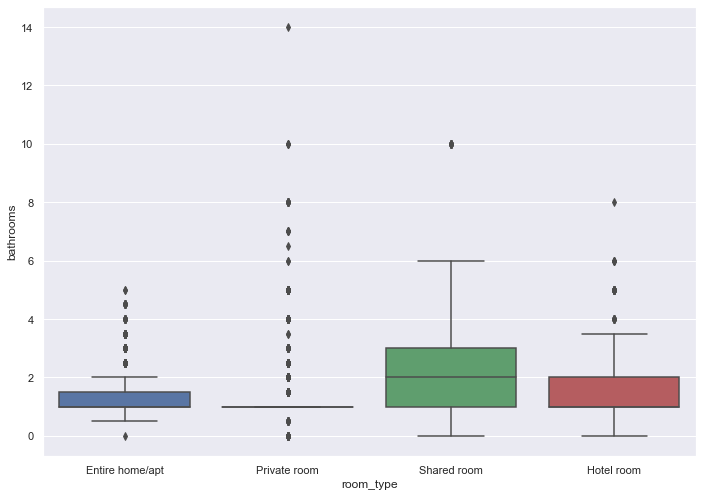

In [29]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
_ = sns.boxplot(data=data, x='room_type', y='bathrooms')

Indeed 3 property types exhibit a large average of bathrooms number, and all of them belong to the same rare `property types` that exhibited similar trend with `bedrooms`.

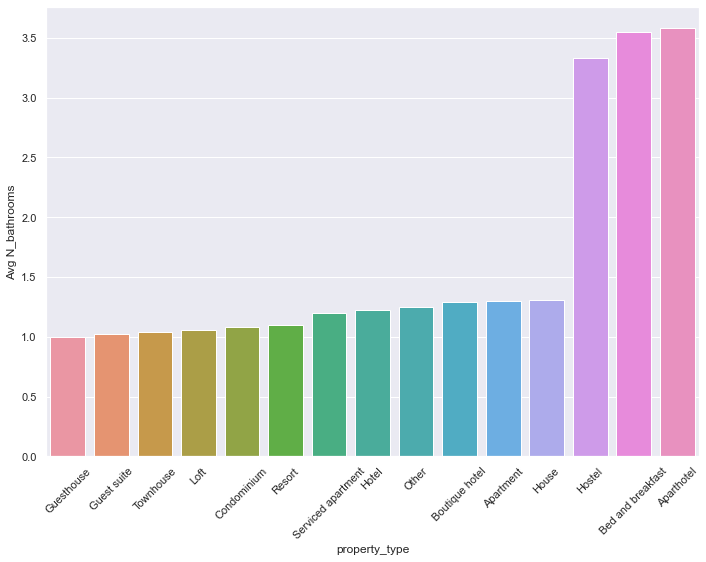

In [30]:
ax = sns.barplot(
    data=private_room.groupby('property_type', as_index=False).agg({'bathrooms':'mean'}).sort_values(by='bathrooms'), 
    x='property_type', y='bathrooms')

locs, labels = plt.xticks()
plt.ylabel('Avg N_bathrooms')
_ = plt.setp(labels, rotation=45)

## Minimum Nights

There is an outlier point under `maximum_nights` columns, as there is 7 orders of magnitude difference between the maximum value and the 99% percentile value.



In [31]:
pd.DataFrame(df.minimum_nights.describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99]))

,minimum_nights
count,7.077000e+03
mean,1.414624e+04
std,1.188708e+06
min,1.000000e+00
25%,2.000000e+00
50%,4.000000e+00
75%,3.000000e+01
95%,3.000000e+01
99%,7.120000e+01
max,1.000000e+08


A pattern is also seen for `minimum_nights` under the value `7`; `price` is more likely to be higher for rooms with larger value of `minimum_nights`, however the variance in the data is very large especially for larger values of `minimum_nights`. 

<AxesSubplot:xlabel='minimum_nights', ylabel='price'>

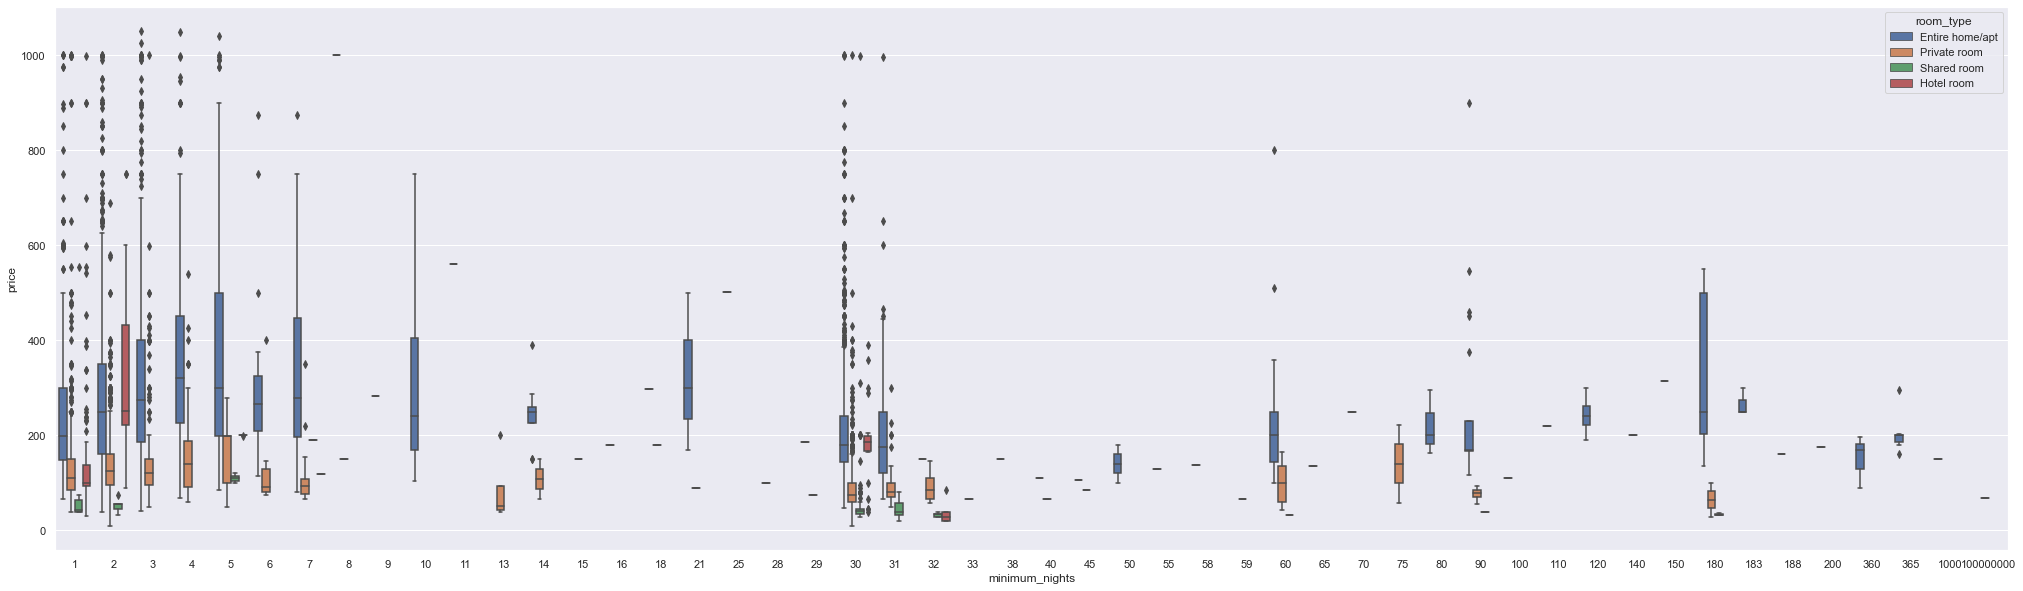

In [32]:
plt.figure(figsize=(35, 10))
sns.boxplot(data=df, x='minimum_nights', y='price', hue='room_type')

# Bivariate analysis
## Effect of number of bedrooms on price

* Price is higher for rooms with larger number of bedrooms


<AxesSubplot:xlabel='bedrooms', ylabel='price'>

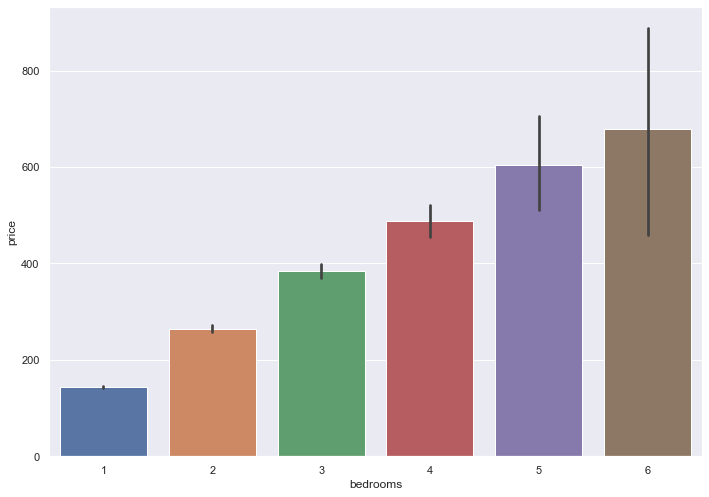

In [33]:
sns.barplot(data=df, x='bedrooms', y='price')

* All room types seem to be following an upwards trend in price with the increase in number of bedrooms except `Private room` which, began to fall after 3 bedrooms, maybe these values are invalid.

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

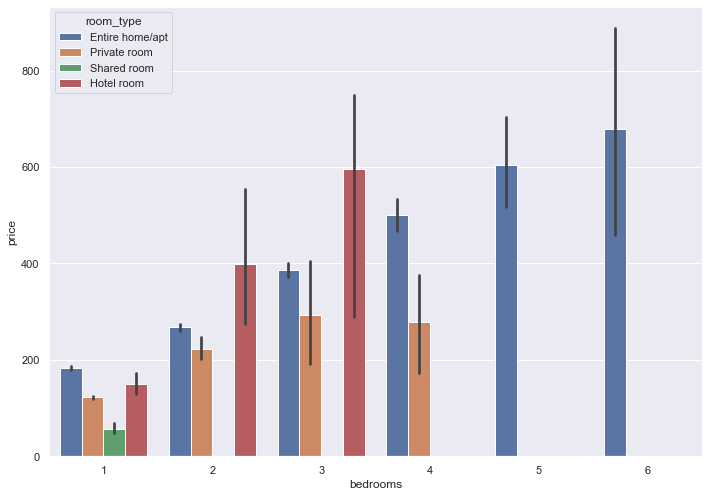

In [34]:
sns.barplot(data=df, x='bedrooms', y='price', hue='room_type')

## Effect of number of bathrooms
* An upward trend is seen with `Entire home/apt` for prices. 

<AxesSubplot:xlabel='bathrooms', ylabel='price'>

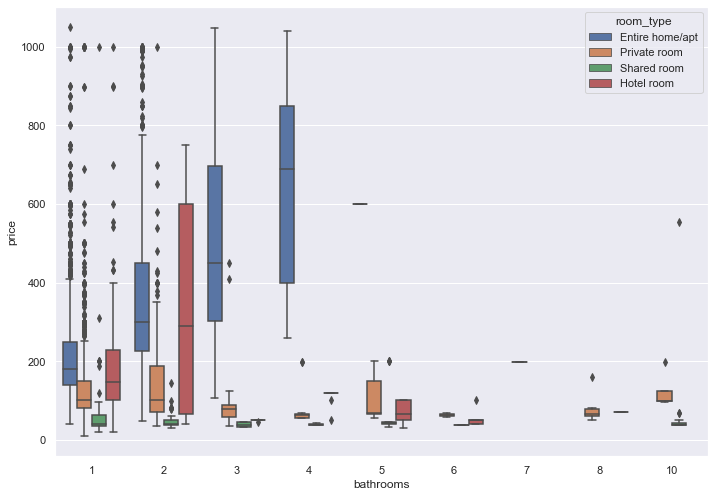

In [35]:
sns.boxplot(data=df, x='bathrooms', y='price', hue='room_type')

## Effect of porperty type on price

Varying property types indeed have different pricing.

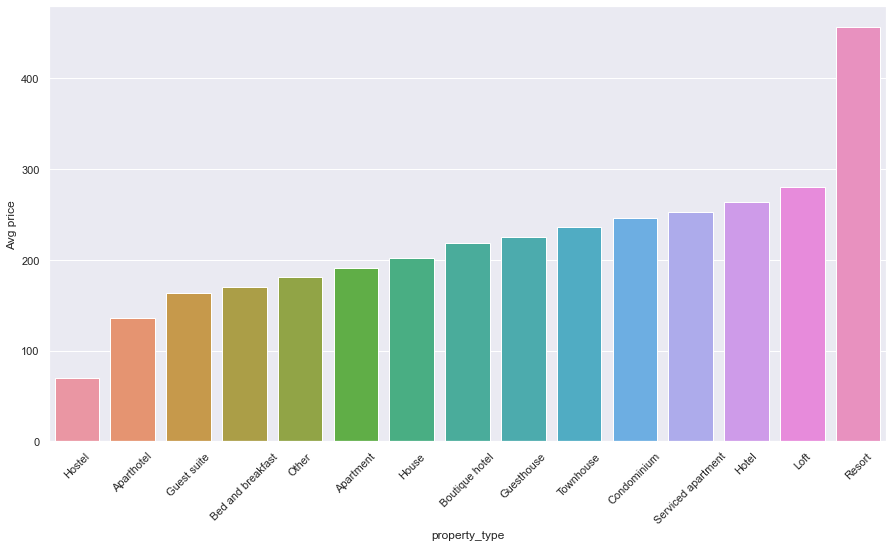

In [36]:
plt.figure(figsize = (15,8))
ax = sns.barplot(data=df.groupby('property_type', as_index=False).agg({'price':'mean'}).sort_values(by='price'), x='property_type', y='price')
locs, labels = plt.xticks()
plt.ylabel('Avg price')
_ = plt.setp(labels, rotation=45)

## Effect of room type on price

* More private listings generally have higher prices furthermore.
* The larger the number of bedrooms the more expensive the listing is.

<AxesSubplot:xlabel='room_type', ylabel='price'>

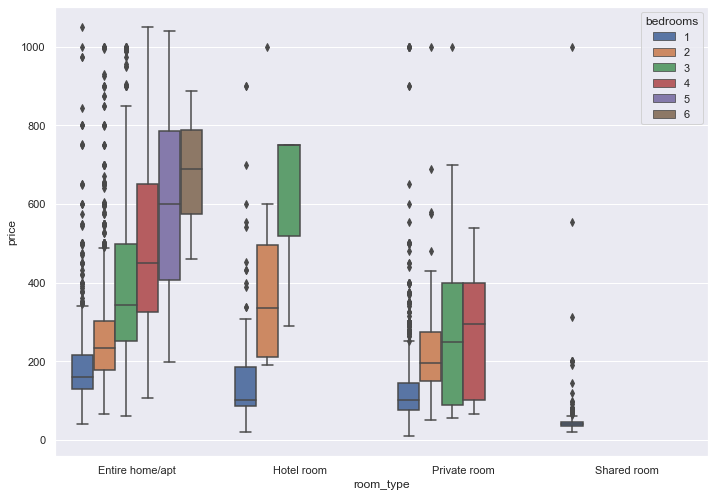

In [37]:
sns.boxplot(data=df, x='room_type', hue='bedrooms', y='price', order=['Entire home/apt', 'Hotel room', 'Private room', 'Shared room'])

## Effect of Position on price

Based on this map, it seems as though most of the listings are clustered at the center of the city and towards the northeast. This makes sense, since the center region is the heart of downtown San Francisco, and the northeast is next to the bay, which has many tourist attractions.

Surprisingly, there is no clear pattern shown by the location variables `latitude` and `longitude`. The reason could that the variables in the data are not capable of capturing such trend.

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

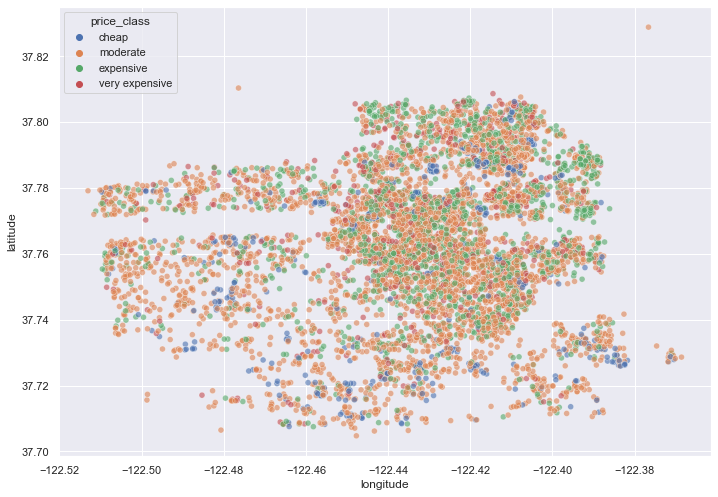

In [38]:
df_prices = df.copy()
df_prices['price_class'] = pd.cut(df_prices.price, bins=[0, 60, 200, 400, 150000], labels=['cheap', 'moderate', 'expensive', 'very expensive'])
sns.scatterplot(data=df_prices, x='longitude', y='latitude', hue='price_class', alpha=0.6)

## Do different property types have different coordinates?

* Uncommon property types; `Boutique hotel`, `Aparthotel`, `Resort` and `Hotel` are clustered more towards the northeast near the shore. 
* Because these property types were more associated with high prices, coordinates should be considered in modeling.

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

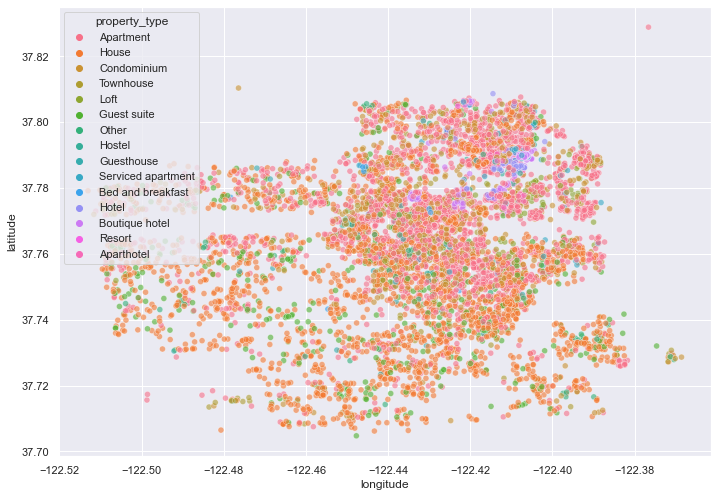

In [39]:
sns.scatterplot(data=df, x='longitude', y='latitude', hue='property_type', alpha=0.6)

# Summary of Insights
1. `price` columns have extreme values $>200$ that could not be justified with the data available for `Boutique hotel`, `Apartment`, `House` and `Town house` 
2. `price` was log transformed and value that are more than 2 standard deviations away from the mean were cut off.
3. Rare property types; `Cottage`, `Bungalow`, `Tiny house`, `Villa`, `Cabin`, `Dome house`, `Castle`, `Earth house` and `Hut` were not so different from `Other` in terms of prices and other properties.
4. Room types `Entire home/apt` and `Private room` are the most frequent among the 4 most common propertiy types.
5. The majority of rentals have only one bedroom and one bathroom.
6. `price` is more likely to be higher for rooms with larger value of `minimum_nights`
7. Number of bedrooms is positively correlated with `price`.
8. Number of bathrooms for `Entire home/apt` is positively correlated with `price`.
9. More private listings have higher prices.
10. Majority of listings are clustered at the center of the city and towards the northeast. However, coordinates do no seem to be directly associated with price. 

# Prepare dataset for modeling

In [40]:
def clean_data(df):
    df.dropna(inplace=True)
    df.price = df.price.str.replace('$', '', regex=False)
    df.price = df.price.str.replace(',', '', regex=False)
    df.price = df.price.astype('float')
    df = df.loc[(df.price > 0)]
    return df

data = clean_data(data)
price_log = np.log(data.price)

# Isolate data based on EDA insights
data = data[
    (data.bedrooms > 0) & 
    (data.bedrooms < 6) &
    (data.bathrooms < 4) &
    (data.minimum_nights < 366) &
    (price_log < (2.5 * price_log.std() + price_log.mean()))]

print(data.shape)

(6863, 8)


In [41]:
prop_encoder = LabelEncoder()
room_encoder = LabelEncoder()
def prepare_features(df):
    df[['bedrooms', 'bathrooms']] = df[['bedrooms', 'bathrooms']].astype(int)
    df = df.replace(['Cottage', 'Bungalow', 'Tiny house', 'Villa', 'Cabin', 'Dome house', 'Castle', 'Earth house', 'Hut'], 'Other')

    df['property_type'] = prop_encoder.fit_transform(df['property_type'])
    df['room_type'] = room_encoder.fit_transform(df['room_type'])
    return df
    
data = prepare_features(data)

## Split dataset

In [42]:
features = ['bedrooms', 'bathrooms', 'property_type', 'room_type', 'latitude', 'longitude', 'minimum_nights']
X_train, X_test, y_train, y_test = train_test_split(data[features], data.price, random_state=42)

# ML model

A tree based model was chosen for this task, given its robustness against noisy datasets with extreme values. Furthermore, an ensemble model such as Random Forest will prevent overfitting.

Based on the client's requirement for the average prediction error to be below 25 USD, the following metrics were chosen to evaluate the model:
1. Mean Absolute Error
2. Root Mean Squared Error

Root mean squared error gave a higher error than MAE, because the squared error penalizes extreme values, this indicates that the model is having a hard time predicting samples with high prices.

In [43]:
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)
y_preds = model.predict(X_test)
print("Mean absolute error: ", round(mean_absolute_error(y_test, y_preds), 2), ' USD')
print("Root mean square error: ", round(np.sqrt(mean_squared_error(y_test, y_preds)), 2), " USD")

Mean absolute error:  59.01  USD
Root mean square error:  96.09  USD


Predictions that achieved the client's requirements are more dense under prices of 200 USD, indicating that the model is having a hard time learning samples with high prices from the features available.

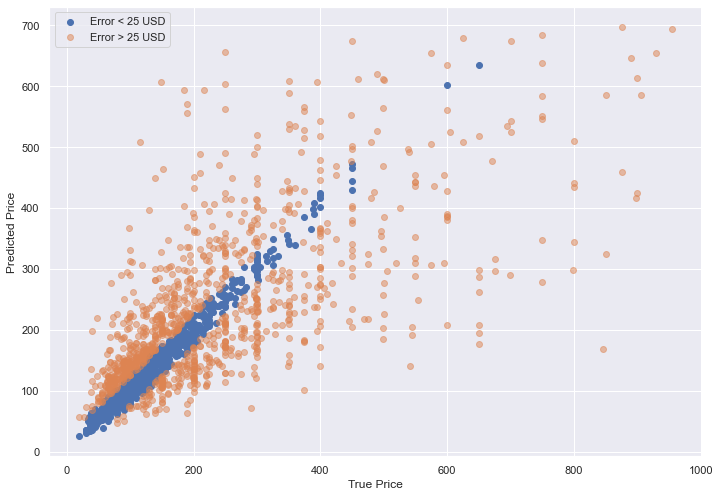

In [44]:
below_thresh = list(np.where(abs(y_preds - y_test) <= 25)[0])
above_thresh = list(np.where(abs(y_preds - y_test) > 25)[0])

plt.scatter(
    y_test.values[below_thresh], 
    y_preds[below_thresh], label='Error < 25 USD')

plt.scatter(
    y_test.values[above_thresh], 
    y_preds[above_thresh], alpha=0.5, label='Error > 25 USD')

_ = plt.legend()
_ = plt.ylabel('Predicted Price')
_ = plt.xlabel('True Price')

# Future work and recommendations

### Outliers
The dataset contained many extreme values that require domain knowledge to clean and get more accurate results. 

### Features and Data collection
The features present in the dataset were not able to capture the extreme variances in prices for each category. It is recommended to collect more features that would help explain these variances, such as; 
* Amenities
* Neighbourhood user ratings
* Property ratings
* Year


